In [1]:
import pandas as pd

# 데이터 불러오기 
data = pd.read_csv('raw_data/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')
data.head(10)
print(data.shape)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_28656\4287711130.py:4: DtypeWarning: Columns (1,2,7,11,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('raw_data/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')


(2622133, 38)


In [2]:
from utils.preprocess_drop import preprocess_and_drop_columns

df_cleaned = preprocess_and_drop_columns(data)


c:\Aicamp\SKN13-2nd-7Team\utils\preprocess_drop.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Length of Stay'] = df['Length of Stay'].astype(int)


In [3]:
### 데이터 전처리 - 이상치 처리 
from utils.cate_outlier import replace_rare_categories
from utils.num_outlier import remove_zscore_outliers_all
import pandas as pd

num_columns = ['Total Charges', 'Total Costs', 'Length of Stay']
cate_columns = [col for col in df_cleaned.columns
                if col not in num_columns + ['Patient Disposition']] # target = 'Patient Disposition'

# 이상치 대체 및 삭제

# 1단계: 범주형 컬럼의 희귀값을 'Others'로 대체
df_replaced = replace_rare_categories(df_cleaned, columns=cate_columns, threshold=0.001)

# 2단계: 수치형 컬럼의 Z-score 이상치를 제거
df = remove_zscore_outliers_all(df_replaced, columns=num_columns, z_thresh=2)

df.shape

(2481639, 29)

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# utils 모듈에서 함수 및 클래스 불러오기
from utils.preprocessing_utils import (
    create_categorical_pipeline,
    create_numeric_pipeline,
    split_data,
    apply_smote
)
from utils.model_trainer import ModelTrainer

# -------------------------------
# (1) 컬럼 정의
# -------------------------------
# 전처리용 수치형 및 범주형 컬럼 수동 정의 또는 분석 후 추출
num_columns = ['Total Charges', 'Total Costs', 'Length of Stay']
cate_columns = [col for col in df.columns if col not in num_columns + ['Patient Disposition']]

# -------------------------------
# (2) 전처리 파이프라인 생성
# -------------------------------
cat_pipe = create_categorical_pipeline(use_onehot=False)
num_imputer = create_numeric_pipeline().named_steps['knnimputer']  # 스케일링 제외

# -------------------------------
# (3) Train/Test 데이터 분할
# -------------------------------
X_train, X_test, y_train, y_test = split_data(df)

# -------------------------------
# (4) 범주형 인코딩 + 결측치 처리 (스케일링 없이)
# -------------------------------
X_train_cat = cat_pipe.fit_transform(X_train[cate_columns])
X_train_num = num_imputer.fit_transform(X_train[num_columns])
X_train_combined = np.hstack([X_train_cat, X_train_num])

# -------------------------------
# (5) SMOTE (train set에만)
# -------------------------------
X_train_resampled, y_train_resampled = apply_smote(X_train_combined, y_train)

# -------------------------------
# (6) 스케일링 (SMOTE 이후)
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# 테스트셋 전처리 (transform만)
X_test_cat = cat_pipe.transform(X_test[cate_columns])
X_test_num = num_imputer.transform(X_test[num_columns])
X_test_combined = np.hstack([X_test_cat, X_test_num])
X_test_scaled = scaler.transform(X_test_combined)


c:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Playdata\AppData\Local\mi

In [5]:

# -------------------------------
# (7) 모델별 학습 및 평가 (preprocessor 없이)
# -------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

models = {
    # 'LogisticRegression': LogisticRegression(),
    # 'KNNNeighbors': KNeighborsClassifier(),
    # 'Decision Tree': DecisionTreeClassifier(),
    # 'Random Forest': RandomForestClassifier(),
    # 'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

results = []

for name, model in models.items():
    trainer = ModelTrainer(model) 
    trainer.fit(X_train_scaled, y_train_resampled)
    result = trainer.evaluate(X_test_scaled, y_test)
    result['Model'] = name
    results.append(result)
2
# -------------------------------
# (8) 결과 출력
# -------------------------------
for res in results:
    print(
        f"{res['Model']}: "
        f"Accuracy={res['Accuracy']:.4f}, "
        f"Precision={res['Precision']:.4f}, "
        f"Recall={res['Recall']:.4f}, "
        f"F1 Score={res['F1 Score']:.4f}"
    )


XGBoost: Accuracy=0.9844, Precision=0.9558, Recall=0.3282, F1 Score=0.4886


In [6]:
# 상위 3개 모델 튜닝
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:35:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Parameters:
{'subsample': 0.8, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}

📊 Test Set Evaluation (Best XGBoost):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    727640
           1       0.97      0.33      0.49     16852

    accuracy                           0.98    744492
   macro avg       0.98      0.66      0.74    744492
weighted avg       0.98      0.98      0.98    744492

F1 Score (Test): 0.4878
Threshold | F1 Score | Precision | Recall
-------------------------------------------
     0.10 |   0.4040 |    0.3005 | 0.6161
     0.15 |   0.4698 |    0.4196 | 0.5336
     0.20 |   0.5024 |    0.5387 | 0.4707
     0.25 |   0.5150 |    0.6518 | 0.4257
     0.30 |   0.5153 |    0.7565 | 0.3908
     0.35 |   0.5093 |    0.8343 | 0.3665
     0.40 |   0.5019 |    0.8945 | 0.3488
     0.45 |   0.4940 |    0.9372 | 0.3354
     0.50 |   0.4878 |    0.9656 | 0.3263
     0.55 

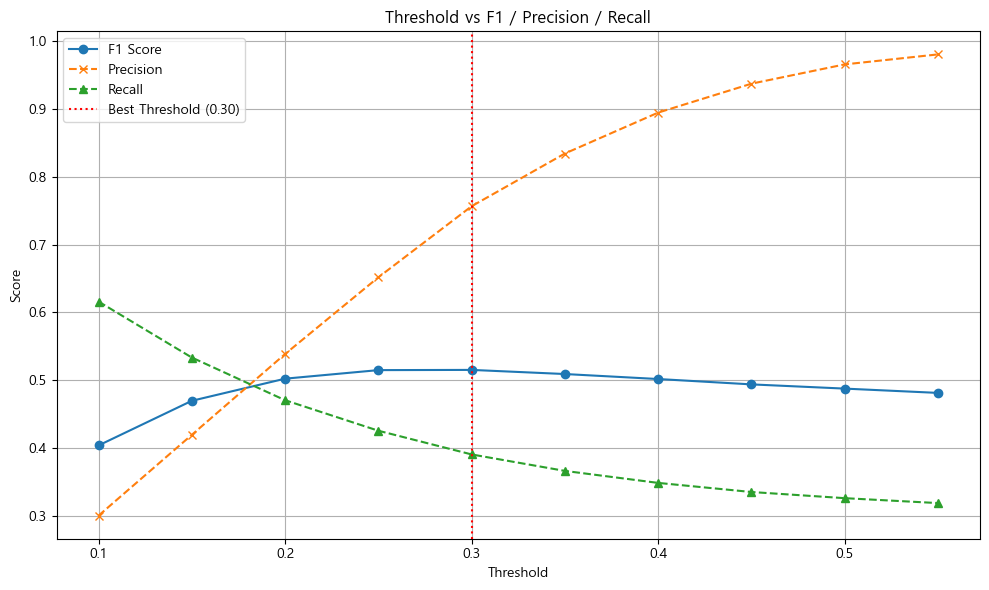

In [15]:
from xgboost import XGBClassifier

# 모델 정의
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 하이퍼파라미터 후보
xgb_param = {
    'n_estimators': [150, 200, 250],
    'max_depth': [4, 5, 6, 7],
    'learning_rate': [0.2, 0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.3, 0.5]
}

# RandomizedSearchCV 객체 정의
xgb_rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param,
    scoring='f1',
    n_iter=20,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 튜닝 시작
xgb_rs.fit(X_train_scaled, y_train_resampled)

# 결과 출력
print("✅ Best Parameters:")
print(xgb_rs.best_params_)

# 최적 모델로 테스트셋 평가
from sklearn.metrics import classification_report, f1_score

y_pred_xgb = xgb_rs.predict(X_test_scaled)
print("\n📊 Test Set Evaluation (Best XGBoost):")
print(classification_report(y_test, y_pred_xgb))
print(f"F1 Score (Test): {f1_score(y_test, y_pred_xgb):.4f}")


# --- ✅ (3) threshold 실험 코드 바로 붙이기 ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

y_proba = xgb_rs.predict_proba(X_test_scaled)[:, 1]
thresholds = np.arange(0.1, 0.6, 0.05)

f1s, precisions, recalls = [], [], []
best_f1 = 0
best_threshold = 0.5

print("Threshold | F1 Score | Precision | Recall")
print("-------------------------------------------")
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    
    print(f"{t:9.2f} | {f1:8.4f} | {precision:9.4f} | {recall:6.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n✅ 최적 Threshold: {best_threshold:.2f}, F1 Score: {best_f1:.4f}")

plt.figure(figsize=(10,6))
plt.plot(thresholds, f1s, marker='o', label='F1 Score')
plt.plot(thresholds, precisions, marker='x', linestyle='--', label='Precision')
plt.plot(thresholds, recalls, marker='^', linestyle='--', label='Recall')
plt.axvline(x=best_threshold, color='red', linestyle=':', label=f'Best Threshold ({best_threshold:.2f})')
plt.title("Threshold vs F1 / Precision / Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


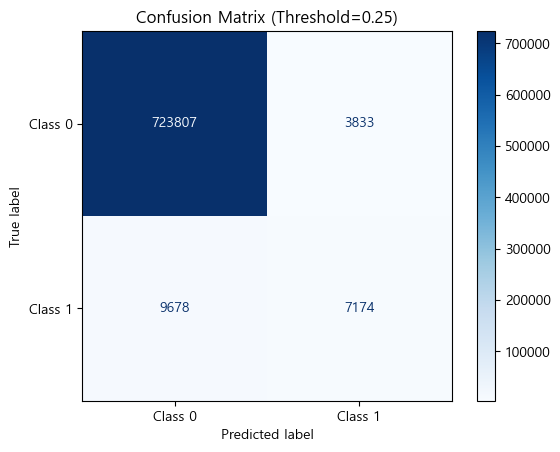

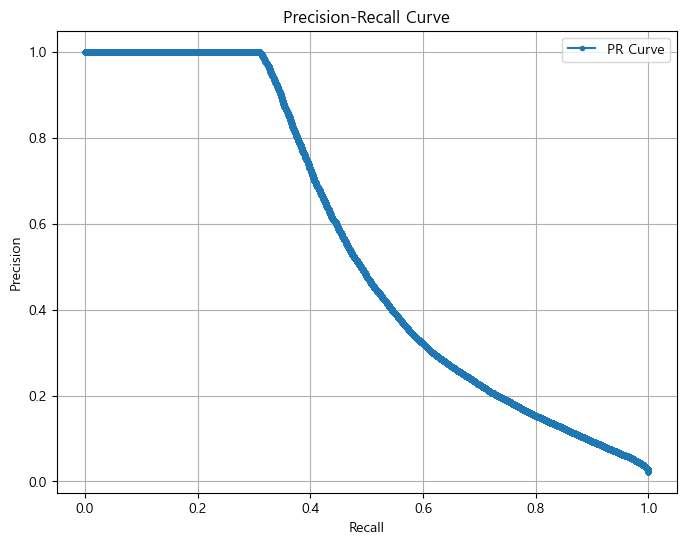

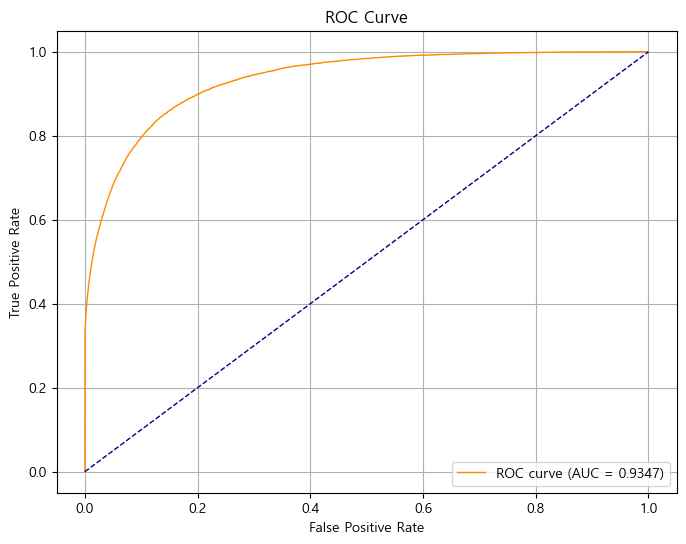

In [16]:
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# 예측 확률
y_proba = xgb_rs.predict_proba(X_test_scaled)[:, 1]
best_threshold = 0.25
y_pred_best = (y_proba >= best_threshold).astype(int)

# -------------------------------
# 1. Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (Threshold={best_threshold})")
plt.show()

# -------------------------------
# 2. Precision-Recall Curve
# -------------------------------
precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, marker='.', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------
# 3. ROC Curve
# -------------------------------
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [17]:
import joblib
import json

# (1) 최적 모델 저장
best_model = xgb_rs.best_estimator_
joblib.dump(best_model, 'best_xgb_model.pkl')  # Pickle file로 저장

# (2) 최적 threshold 저장
best_threshold = 0.25
with open('best_threshold.json', 'w') as f:
    json.dump({'threshold': best_threshold}, f)

print("✅ 모델과 threshold 저장 완료!")


✅ 모델과 threshold 저장 완료!


In [8]:
# from sklearn.ensemble import RandomForestClassifier

# # 모델 정의
# rf = RandomForestClassifier(random_state=42)

# # 하이퍼파라미터 후보
# rf_param = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }

# # RandomizedSearchCV 객체 정의
# rf_rs = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=rf_param,
#     scoring='f1',
#     n_iter=20,
#     cv=3,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # 튜닝 시작
# rf_rs.fit(X_train_scaled, y_train_resampled)

# # 결과 출력
# print("✅ Best Parameters (Random Forest):")
# print(rf_rs.best_params_)

# # 최적 모델로 테스트셋 평가
# from sklearn.metrics import classification_report, f1_score

# y_pred_rf = rf_rs.predict(X_test_scaled)
# print("\n📊 Test Set Evaluation (Best Random Forest):")
# print(classification_report(y_test, y_pred_rf))
# print(f"F1 Score (Test): {f1_score(y_test, y_pred_rf):.4f}")



In [9]:
# from sklearn.ensemble import GradientBoostingClassifier

# # 모델 정의
# gb = GradientBoostingClassifier(random_state=42)

# # 하이퍼파라미터 후보
# gb_param = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.6, 0.8, 1.0],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # RandomizedSearchCV 객체 정의
# gb_rs = RandomizedSearchCV(
#     estimator=gb,
#     param_distributions=gb_param,
#     scoring='f1',
#     n_iter=20,
#     cv=3,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # 튜닝 시작
# gb_rs.fit(X_train_scaled, y_train_resampled)

# # 결과 출력
# print("✅ Best Parameters (Gradient Boosting):")
# print(gb_rs.best_params_)

# # 최적 모델로 테스트셋 평가
# y_pred_gb = gb_rs.predict(X_test_scaled)
# print("\n📊 Test Set Evaluation (Best Gradient Boosting):")
# print(classification_report(y_test, y_pred_gb))
# print(f"F1 Score (Test): {f1_score(y_test, y_pred_gb):.4f}")


In [10]:
# # 데이터 크기 vs F1 Score 실험 코드
# # F1 Score가 작은 이유 찾기

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import f1_score
# from utils.preprocessing_utils import (
#     create_categorical_pipeline, create_numeric_pipeline, apply_smote
# )

# # (1) 컬럼 분리
# num_columns = ['Total Charges', 'Total Costs', 'Length of Stay']
# cate_columns = [col for col in df.columns if col not in num_columns + ['Patient Disposition']]

# # (2) F1 Score vs 데이터 크기 실험
# sample_sizes = [0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31]
# f1_scores = []

# def get_xy(df, target_col='Patient Disposition', positive_class='Left Against Medical Advice'):
#     X = df.drop(columns=[target_col])
#     y = np.where(df[target_col].values == positive_class, 1, 0)
#     return X, y

# cat_pipe = create_categorical_pipeline(use_onehot=False)
# num_imputer = create_numeric_pipeline().named_steps['knnimputer']

# X_all, y_all = get_xy(df)

# for s in sample_sizes:
#     print(f"\n✅ 데이터 비율 {s*100:.1f}% 실험 시작")

#     # 데이터 분할
#     X_train, X_test, y_train, y_test = train_test_split(
#         X_all, y_all, train_size=s, test_size=s, stratify=y_all, random_state=42
#     )

#     # 전처리
#     X_train_cat = cat_pipe.fit_transform(X_train[cate_columns])
#     X_train_num = num_imputer.fit_transform(X_train[num_columns])
#     X_train_combined = np.hstack([X_train_cat, X_train_num])

#     X_test_cat = cat_pipe.transform(X_test[cate_columns])
#     X_test_num = num_imputer.transform(X_test[num_columns])
#     X_test_combined = np.hstack([X_test_cat, X_test_num])

#     # SMOTE + 스케일링
#     X_train_resampled, y_train_resampled = apply_smote(X_train_combined, y_train)
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train_resampled)
#     X_test_scaled = scaler.transform(X_test_combined)

#     # 모델 훈련 및 예측
#     model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
#     model.fit(X_train_scaled, y_train_resampled)
#     y_pred = model.predict(X_test_scaled)

#     # F1 Score 계산
#     f1 = f1_score(y_test, y_pred)
#     f1_scores.append(f1)
#     print(f"📊 F1 Score: {f1:.4f}")

# # 결과 시각화
# plt.plot(np.array(sample_sizes) * 100, f1_scores, marker='o')
# plt.title("F1 Score vs Sample Size (%)")
# plt.xlabel("Train/Test Sample Size (%)")
# plt.ylabel("F1 Score")
# plt.grid(True)
# plt.show()

# # 증가폭 확인
# diffs = np.diff(f1_scores)
# print("F1 증가폭:", diffs)